### Section C2 - Z0 Boson Decay Flavour Tagging

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Normalization

import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.models import load_model
from keras.utils import to_categorical
import seaborn as sns
import ast
import random
from scipy.stats import zscore
import importlib

import uproot
from IPython.display import display
import time

In [2]:
import utils.data_create
import utils.model

importlib.reload(utils.data_create)
importlib.reload(utils.model)

from utils.data_create import *
from utils.model import *

In [3]:
# Set random seeds for reproducibility
SEED = 42

np.random.seed(SEED)
tf.random.set_seed(SEED)

event_ratio = 0.5
ret_nsize = 50000

### Data Load and Prepare

In [4]:
ft = time.time()
df = load_data(event_ratio).iloc[:ret_nsize]
lt = time.time()

print('time-taken-load-data: ', (lt - ft)/60, ' mins')

display(df.head(5))

print()
print('#Events: ', len(df))

time-taken-load-data:  0.47982881863911947  mins


,Thrust_x,Thrust_y,Thrust_z,nParticle,nVertex,Vertex_chi2,Vertex_ntracks,Vertex_chi2_mean,Vertex_chi2_std,Particle_p,Particle_pt,label,Particle_p_mean,Particle_pt_mean
0,-0.988508,0.134821,0.068380,51,5,"[1.2062841653823853, 1.4833343029022217, 1.071...",1.174039,5.40,0.547516,"[17.110713958740234, 15.590205192565918, 8.124...","[17.070255279541016, 15.511972427368164, 8.078...",2,1.756450,1.699754
1,-0.169714,-0.235583,-0.956921,27,4,"[1.4198030233383179, 0.851168692111969, 0.7911...",2.403861,4.00,2.408210,"[15.801677703857422, 14.56035041809082, 8.6645...","[4.877500057220459, 4.558538913726807, 3.39752...",1,3.185484,1.136384
2,-0.461889,0.883966,0.072537,62,4,"[1.1004678010940552, 0.55350661277771, 0.09913...",0.582173,5.75,0.354548,"[6.930073261260986, 6.699347019195557, 4.44919...","[6.891113758087158, 6.557742595672607, 4.36802...",1,1.384079,1.229791
3,-0.471590,-0.236001,-0.849651,40,4,"[0.9219660758972168, 0.6894498467445374, 1.163...",0.833427,5.25,0.230449,"[18.415950775146484, 13.617561340332031, 9.829...","[11.56556510925293, 6.092804431915283, 5.88711...",0,2.035524,1.142261
4,-0.459001,0.094859,-0.883357,25,1,[0.9347887635231018],0.934789,14.00,0.000000,"[28.55536651611328, 26.88994598388672, 13.1161...","[15.440359115600586, 12.474578857421875, 5.948...",2,3.580825,1.737834



#Events:  50000


At each event an arbitary number of particles can decay (>1) --> taking average of that scaler momentum 

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Thrust_x          50000 non-null  float64
 1   Thrust_y          50000 non-null  float64
 2   Thrust_z          50000 non-null  float64
 3   nParticle         50000 non-null  int32  
 4   nVertex           50000 non-null  int32  
 5   Vertex_chi2       50000 non-null  object 
 6   Vertex_ntracks    50000 non-null  float64
 7   Vertex_chi2_mean  50000 non-null  float64
 8   Vertex_chi2_std   50000 non-null  float64
 9   Particle_p        50000 non-null  object 
 10  Particle_pt       50000 non-null  object 
 11  label             50000 non-null  int64  
 12  Particle_p_mean   50000 non-null  float64
 13  Particle_pt_mean  50000 non-null  float64
dtypes: float64(8), int32(2), int64(1), object(3)
memory usage: 5.0+ MB


C:\Users\Alik\AppData\Local\Temp\ipykernel_19036\3231144271.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['label'], palette="Set2", ax=axes[2, 2])


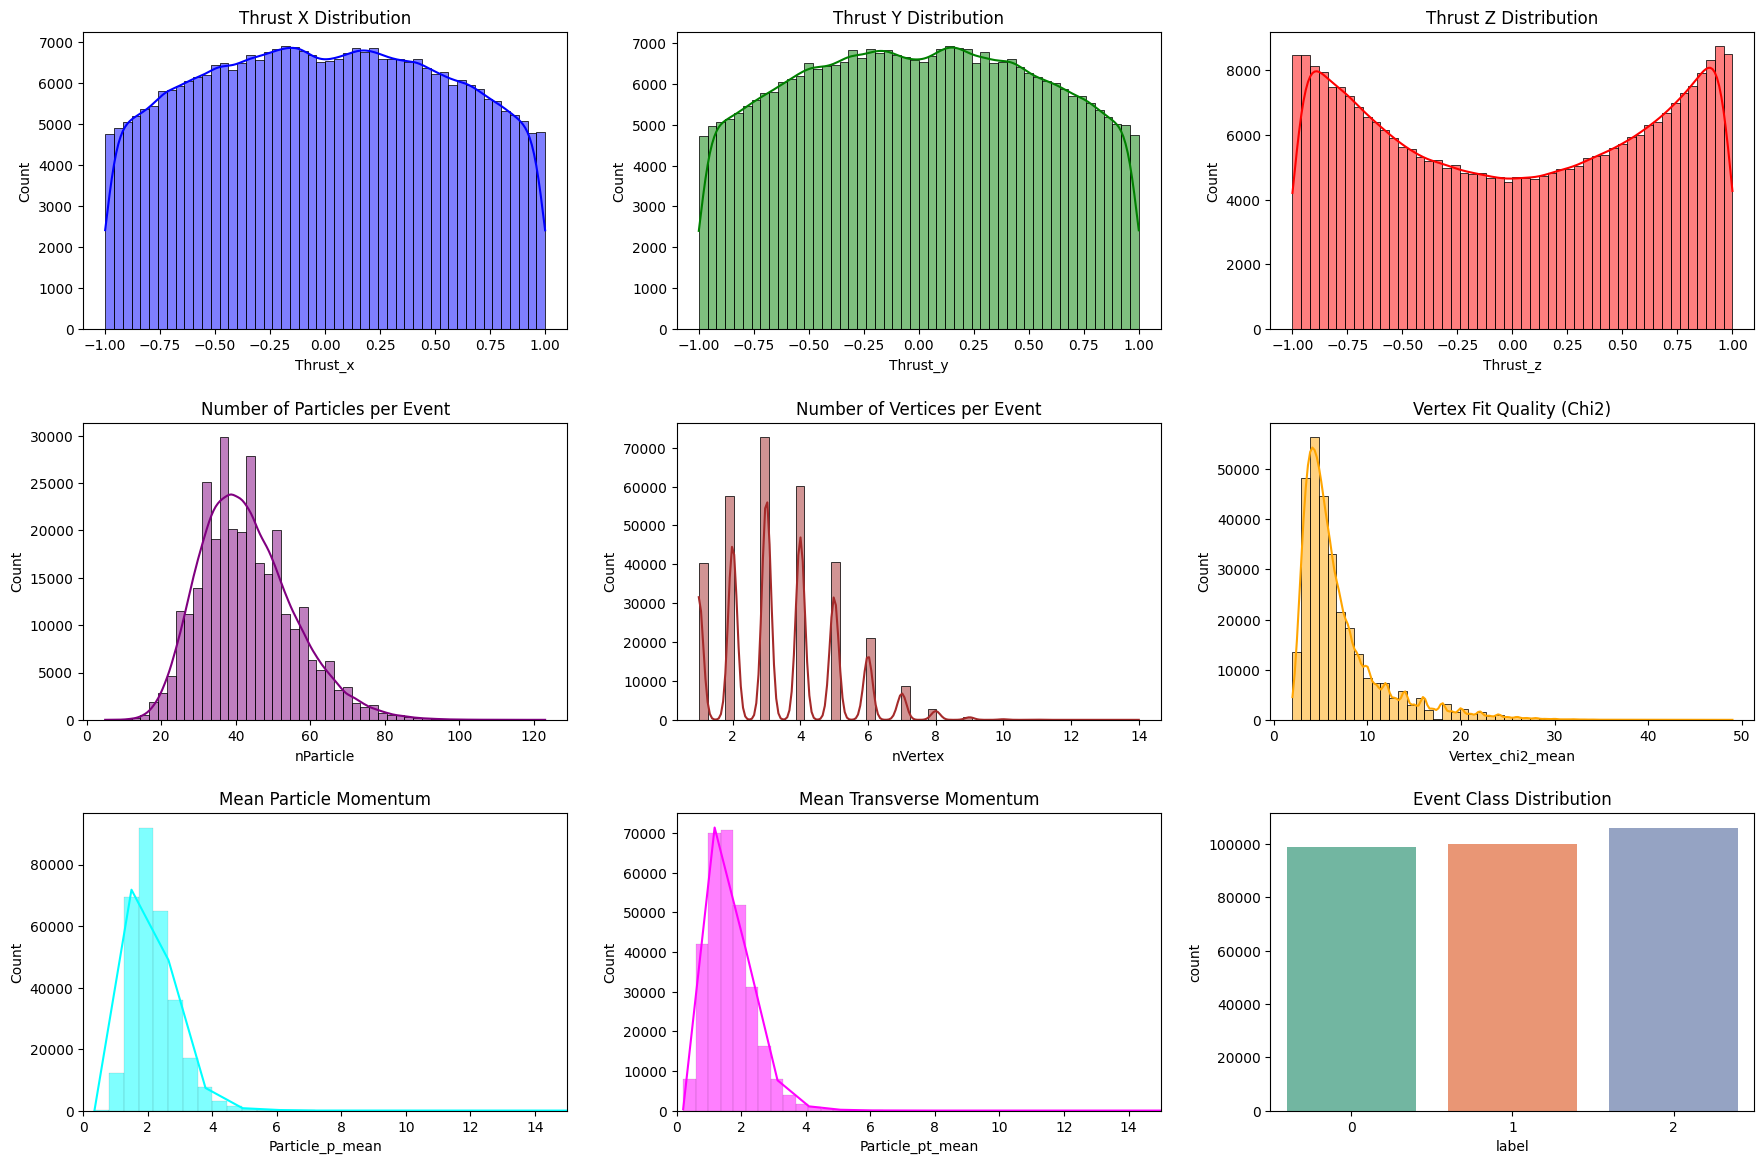

In [43]:
def visualize_data(df):
    """Generates a 3x3 grid of plots to understand the dataset."""
    
    fig, axes = plt.subplots(3, 3, figsize=(18, 12))

    # Thrust Distributions
    sns.histplot(df['Thrust_x'], kde=True, bins=50, color='blue', ax=axes[0, 0])
    axes[0, 0].set_title('Thrust X Distribution')

    sns.histplot(df['Thrust_y'], kde=True, bins=50, color='green', ax=axes[0, 1])
    axes[0, 1].set_title('Thrust Y Distribution')

    sns.histplot(df['Thrust_z'], kde=True, bins=50, color='red', ax=axes[0, 2])
    axes[0, 2].set_title('Thrust Z Distribution')

    # Particle and Vertex Counts
    sns.histplot(df['nParticle'], kde=True, bins=50, color='purple', ax=axes[1, 0])
    axes[1, 0].set_title('Number of Particles per Event')

    sns.histplot(df['nVertex'], kde=True, bins=50, color='brown', ax=axes[1, 1])
    axes[1, 1].set_title('Number of Vertices per Event')

    sns.histplot(df['Vertex_chi2_mean'], kde=True, bins=50, color='orange', ax=axes[1, 2])
    axes[1, 2].set_title('Vertex Fit Quality (Chi2)')

    # Momentum and Charge
    sns.histplot(df['Particle_p_mean'], kde=True, bins=500, color='cyan', ax=axes[2, 0])
    axes[2, 0].set_title('Mean Particle Momentum')
    axes[2, 0].set_xlim(0, 15.0)

    sns.histplot(df['Particle_pt_mean'], kde=True, bins=500, color='magenta', ax=axes[2, 1])
    axes[2, 1].set_title('Mean Transverse Momentum')
    axes[2, 1].set_xlim(0, 15.0)

    sns.countplot(x=df['label'], palette="Set2", ax=axes[2, 2])
    axes[2, 2].set_title('Event Class Distribution')

    plt.tight_layout(pad=2)
    plt.savefig('saves/plots/dataset_grid_c2.png')
    plt.show()

visualize_data(df)

In [10]:
df_eventwise = df.drop(['Particle_p', 'Particle_pt', "Vertex_chi2"], axis=1).dropna()

df_eventwise.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Thrust_x          50000 non-null  float64
 1   Thrust_y          50000 non-null  float64
 2   Thrust_z          50000 non-null  float64
 3   nParticle         50000 non-null  int32  
 4   nVertex           50000 non-null  int32  
 5   Vertex_ntracks    50000 non-null  float64
 6   Vertex_chi2_mean  50000 non-null  float64
 7   Vertex_chi2_std   50000 non-null  float64
 8   label             50000 non-null  int64  
 9   Particle_p_mean   50000 non-null  float64
 10  Particle_pt_mean  50000 non-null  float64
dtypes: float64(8), int32(2), int64(1)
memory usage: 3.8 MB


In [17]:
def extract_features(events, labels):
    """
    Extract features from events for input to neural networks.
    
    Returns:
        X: Array of event features for each event
        y: Labels
    """

    events = np.array(events)
    labels = np.array(labels)

    n_events = len(events)

    # Define feature dimensions
    n_event_features = events.shape[-1]  # Thrust_x, Thrust_y, Thrust_z, nParticle, nVertex, Vertex_ntracks, Vertex_chi2_mean, Vertex_chi2_std, Particle_p, Particle_pt, Particle_q
    
    # Initialize arrays for event-level features and labels
    X = np.zeros((n_events, n_event_features))
    y = np.zeros(n_events, dtype=int)
    
    # Fill arrays with data
    for i, event in enumerate(events):
        # Fill label
        y[i] = labels[i]

        # Extract event-level features (thrust, particle, vertex, etc.)
        for j in range(n_event_features):
            X[i, j] = event[j]

    return X, y

# Extract features
X, y = extract_features(df_eventwise.drop(['label'], axis=1), df.label)
print(np.unique(y))

rn_idx = np.random.permutation(len(y))  # Generate a random permutation of indices
X, y = zip(*[(X[i], y[i]) for i in rn_idx])
X, y = np.array(X), np.array(y)

# Split data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.05, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.15, random_state=42
)

print("Data split complete:")
print(f"Training: {len(y_train)} samples | X-train-shape: {X_train.shape}, y-train-shape: {y_train.shape} | UNQ-check: {np.unique(y_train)}")
print(f"Validation: {len(y_val)} samples | X-val-shape: {X_val.shape}, y-val-shape: {y_val.shape}")
print(f"Test: {len(y_test)} samples | X-shape: {X_test.shape}, y-shape: {y_test.shape}")

[0 1 2]
Data split complete:
Training: 40375 samples | X-train-shape: (40375, 10), y-train-shape: (40375,) | UNQ-check: [0 1 2]
Validation: 7125 samples | X-val-shape: (7125, 10), y-val-shape: (7125,)
Test: 2500 samples | X-shape: (2500, 10), y-shape: (2500,)


In [13]:
def normalize_features(X_train, X_val, X_test):
    # Reshape to 2D for scaling
    orig_shape = X_train.shape
    X_train_flat = X_train.reshape(-1, X_train.shape[-1])
    X_val_flat = X_val.reshape(-1, X_val.shape[-1])
    X_test_flat = X_test.reshape(-1, X_test.shape[-1])
    
    # Fit scaler on training data
    scaler = StandardScaler()
    scaler.fit(X_train_flat)
    
    # Transform all datasets
    X_train_scaled = scaler.transform(X_train_flat).reshape(orig_shape)
    X_val_scaled = scaler.transform(X_val_flat).reshape(X_val.shape)
    X_test_scaled = scaler.transform(X_test_flat).reshape(X_test.shape)
    
    return X_train_scaled, X_val_scaled, X_test_scaled

In [18]:
print(X_train[:, -1])

for i in range(X_train.shape[-1]):
    print('min-max: ', min(X_train[:, i]), max(X_train[:, i]))

[1.79855106 1.9699162  1.62319379 ... 1.09057213 1.53966128 1.41449042]
min-max:  -0.9999810457229614 0.9998529553413391
min-max:  -0.999800443649292 0.9999924898147583
min-max:  -0.9999927282333374 0.9999925494194031
min-max:  10.0 110.0
min-max:  1.0 13.0
min-max:  0.07859648515780766 317744.26027333736
min-max:  2.0 47.0
min-max:  0.0 317742.86472666264
min-max:  0.7680833268910646 8.258494734256105
min-max:  0.2232800120683877 8.134304055859419


#### Z-Score Outlier Filtering

In [19]:
z_scores = np.abs(zscore(X_train, axis=0))


mask = z_scores < 4 ##4-th standard deviation

# print(sum([int(z) for z in mask[:, -2]]))

row_mask = np.all(mask, axis=1)

X_filtered = X_train[row_mask]
y_filtered = y_train[row_mask]

print("Non-Filtered-Shape: ", X_train.shape, y_train.shape)
print("Filtered shapes:", X_filtered.shape, y_filtered.shape)


Non-Filtered-Shape:  (40375, 10) (40375,)
Filtered shapes: (39768, 10) (39768,)


### Save Preprocessd Data

In [20]:
print(X_filtered.shape, X_val.shape, X_test.shape, y_filtered.shape, y_val.shape, y_test.shape)

(39768, 10) (7125, 10) (2500, 10) (39768,) (7125,) (2500,)


In [21]:
np.savez('data/preprocessed/data_eventwise.npz', 
         x_train=X_filtered, x_val=X_val, x_test=X_test, 
         y_train=y_filtered, y_val=y_val, y_test=y_test)

### Model Building 
I took the mean of all the sequential data like Particle_p, Particle_pt, Particle_q converting all of particle level data to event-level - instead we can use sequential models like RNN or permutation invariant architechtures like Deepset, Transformers    

In [22]:
from utils.model import *
from utils.train import *

importlib.reload(utils.model)
importlib.reload(utils.train)

<module 'utils.train' from 'c:\\Users\\Alik\\Desktop\\M_year\\MPhil\\Lent\\A3\\am3353\\utils\\train.py'>

### DNN - Taking everything event-wise - mean of scaler momentum, transverse momentum

In [23]:
normalizer = Normalization(axis=-1) ## feature-wise Normalization (like StandardScaler())  
normalizer.adapt(X_filtered) 

In [24]:
dnn_model = dnn_classifier(X_train.shape[1:], normalizer=normalizer)
dnn_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ event_input (InputLayer)        │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,395 (325.76 KB)

 Trainable params: 83,395 (325.76 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
history, dnn_model = train_dnn([X_filtered, y_filtered], [X_val, y_val], epochs=50)

Epoch 1/50
622/622 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.3489 - loss: 5.8765 - val_accuracy: 0.4859 - val_loss: 14.4823 - learning_rate: 1.0000e-04
Epoch 2/50
622/622 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4090 - loss: 2.8664 - val_accuracy: 0.5309 - val_loss: 5.4179 - learning_rate: 1.0000e-04
Epoch 3/50
622/622 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4698 - loss: 1.9504 - val_accuracy: 0.6717 - val_loss: 1.0405 - learning_rate: 1.0000e-04
Epoch 4/50
622/622 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5288 - loss: 1.5715 - val_accuracy: 0.6647 - val_loss: 0.9108 - learning_rate: 1.0000e-04
Epoch 5/50
622/622 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5687 - loss: 1.2645 - val_accuracy: 0.6719 - val_loss: 0.7984 - learning_rate: 1.0000e-04
Epoch 6/50
622/622 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5941 - loss: 1.1199 - val_accuracy: 0.6685 - val_loss: 0.7606 - learning_rate: 1.0000e-04
Epoch 7/50
622/622 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy:

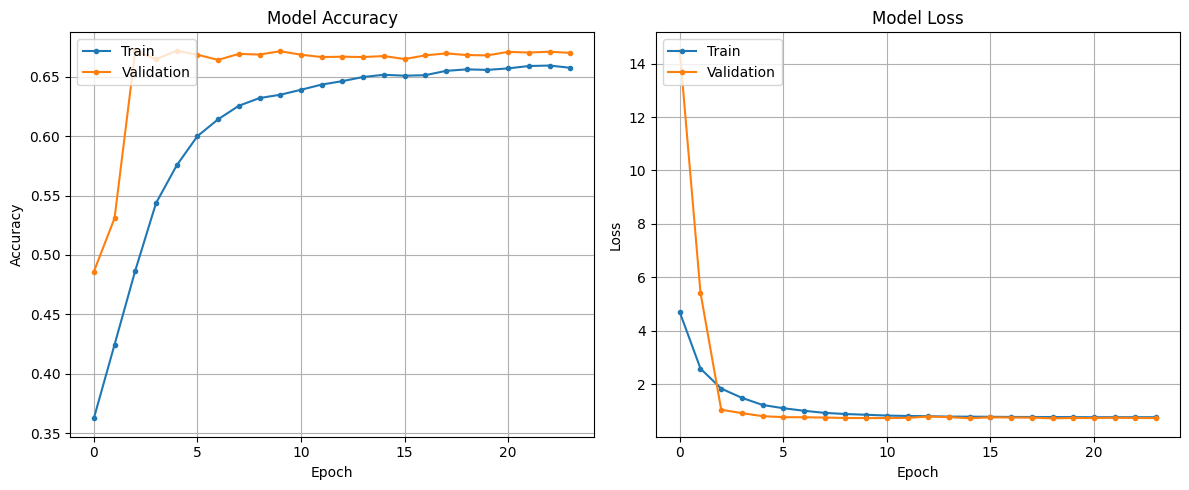

In [26]:
# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], marker = '.')
plt.plot(history.history['val_accuracy'], marker = '.')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], marker = '.')
plt.plot(history.history['val_loss'], marker = '.')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.savefig('saves/plots/fcnn_training_history_c2.png')
plt.show()

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6830 - loss: 0.6992

Test accuracy: 0.6636
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Classification Report:
              precision    recall  f1-score   support

         Zbb       0.68      0.78      0.73       802
         Zcc       0.52      0.55      0.54       838
         Zss       0.83      0.66      0.73       860

   micro avg       0.66      0.66      0.66      2500
   macro avg       0.68      0.67      0.67      2500
weighted avg       0.68      0.66      0.67      2500
 samples avg       0.66      0.66      0.66      2500



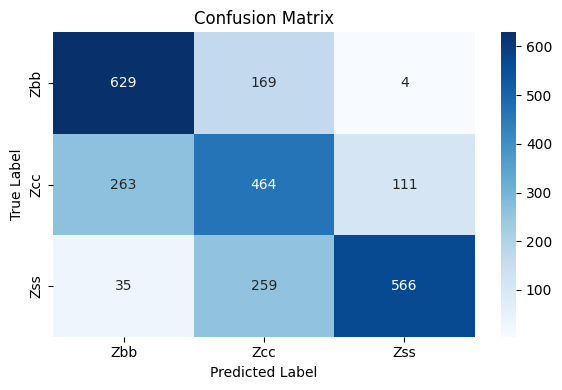

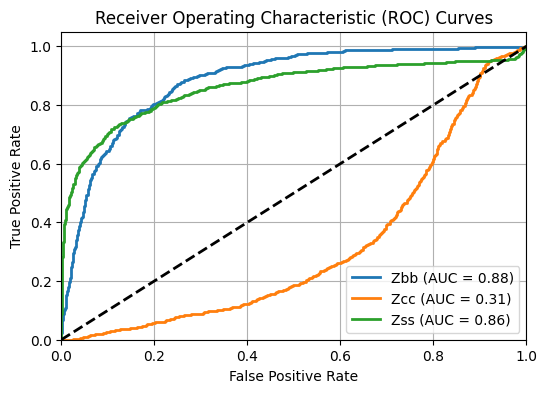

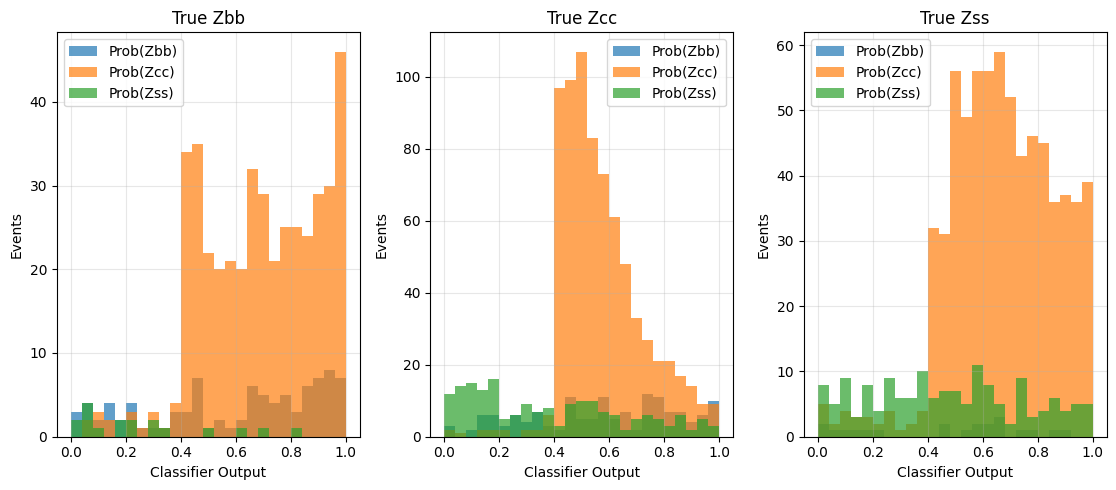

In [27]:

# Evaluate the model on the test set
test_loss, test_acc = dnn_model.evaluate(X_test, y_test)
print(f"\nTest accuracy: {test_acc:.4f}")

# Predict using the dnn_model
y_pred_prob = dnn_model.predict(X_test)  # Model expects one input (X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_pred_one_hot = to_categorical(y_pred, num_classes=3)
y_test_one_hot = to_categorical(y_test, num_classes=3)

# Generate classification report
print("\nClassification Report:")
print(classification_report(y_test_one_hot, y_pred_one_hot, target_names=['Zbb', 'Zcc', 'Zss']))

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Zbb', 'Zcc', 'Zss'],
            yticklabels=['Zbb', 'Zcc', 'Zss'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('saves/plots/fcnn_confusion_matrix_c2.png')
plt.show()

# Plot ROC curves
plt.figure(figsize=(6, 4))

# One-vs-All ROC curves
for i, flavor in enumerate(['Zbb', 'Zcc', 'Zss']):
    # Convert to one-vs-all problem
    y_test_binary = (y_test == i).astype(int)
    
    # Get ROC curve
    fpr, tpr, _ = roc_curve(y_test_binary, y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, lw=2, label=f'{flavor} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('saves/plots/fcnn_roc_curves_c2.png')
plt.show()

# Visualize classifier outputs
plt.figure(figsize=(15, 5))

# Create 4 subplots, one for each flavor (Zbb, Zcc, Zss, Zud)
for i, flavor in enumerate(['Zbb', 'Zcc', 'Zss']):
    plt.subplot(1, 4, i+1)
    
    # Get indices of true examples for this flavor
    true_indices = np.where(y_test == i)[0]
    
    # Plot distribution of classifier outputs for this flavor
    for j, pred_flavor in enumerate(['Zbb', 'Zcc', 'Zss']):
        plt.hist(y_pred_prob[true_indices, j], bins=25, alpha=0.7, 
                 label=f'Prob({pred_flavor})', range=(0, 1))
    
    plt.title(f'True {flavor}')
    plt.xlabel('Classifier Output')
    plt.ylabel('Events')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('saves/plots/fcnn_classifier_outputs_c2.png')
plt.show()

### 2. Sequence Models 

### Seq-Data-Loader

In [29]:
target_cols = ['Vertex_chi2', 'Particle_p', 'Particle_pt']

In [30]:
def z_outlier_filter(x, y): ### Only do outlier filtering for non-array objects

    tmp_x = x[:, 0, :10].reshape(len(x), -1)
    z_scores = np.abs(zscore(tmp_x, axis=0))
    mask = z_scores < 4 ##4-th standard deviation
    row_mask = np.all(mask, axis=1)
    
    X_filtered = x[row_mask]
    y_filtered = y[row_mask]

    return X_filtered, y_filtered

In [31]:
def data_prepare(df, target_cols, pad_val=-999):
    """
    Prepares a combined sequence array for RNN input, repeating scalar features across sequence steps
    and padding variable-length sequence features.

    Args:
        df (pd.DataFrame): input dataframe
        target_cols (list): list of sequence feature columns (e.g., ['Particle_p', 'Particle_pt', 'Particle_q'])
        pad_val (float): padding value for shorter sequences

    Returns:
        np.ndarray: shape (n_events, max_seq_len, n_features)
    """
    # Determine max sequence length
    max_seq_len = max([max(len(seq) for seq in df[col]) for col in target_cols])
    print('Max-Sequence-Len:', max_seq_len)

    n_events = len(df)
    
    # Scalar features (non-sequence ones)
    not_target_cols = [col for col in df.columns if col not in target_cols]
    n_scalar_features = len(not_target_cols)
    n_seq_features = len(target_cols)
    n_total_features = n_scalar_features + n_seq_features

    print('Scaler-Features (Event-level): ', n_scalar_features, ', Seq-Features (Particle-Level): ', n_seq_features)

    # Prepare output array
    arr = np.full((n_events, max_seq_len, n_total_features), pad_val, dtype=np.float32)

    for i in range(n_events):
        # Add scalar features (repeated across time)
        scalar_vals = df.iloc[i][not_target_cols].values.astype(np.float32)
        arr[i, :, :n_scalar_features] = np.repeat(scalar_vals[None, :], max_seq_len, axis=0)

        # Add sequence features (with padding if needed)
        for j, col in enumerate(target_cols):
            seq_vals = np.array(df.iloc[i][col], dtype=np.float32)
            arr[i, :len(seq_vals), n_scalar_features + j] = seq_vals

    return arr


df_sub = df[:100000]
label_seq = np.array(df_sub['label'])
seq_array = data_prepare(df_sub.drop(['label'], axis=1), target_cols)

print(seq_array.shape, label_seq.shape)  # (1000, max_seq_len, 3)

Max-Sequence-Len: 110
Scaler-Features (Event-level):  10 , Seq-Features (Particle-Level):  3
(50000, 110, 13) (50000,)


In [ ]:
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(
    seq_array, label_seq, test_size=0.05, random_state=42, stratify=label_seq
)

X_train_seq, X_val_seq, y_train_seq, y_val_seq = train_test_split(
    X_train_seq, y_train_seq, test_size=0.15, random_state=42, stratify=y_train_seq
)

print(X_train_seq.shape, X_val_seq.shape, X_test_seq.shape)

(40375, 110, 13) (2125, 110, 13) (7500, 110, 13)


In [33]:
import gc
del seq_array, label_seq

gc.collect()

34466

In [34]:
X_filtered_seq, y_filtered_seq = z_outlier_filter(X_train_seq, y_train_seq)
print(X_filtered_seq.shape, y_filtered_seq.shape)

(39839, 110, 13) (39839,)


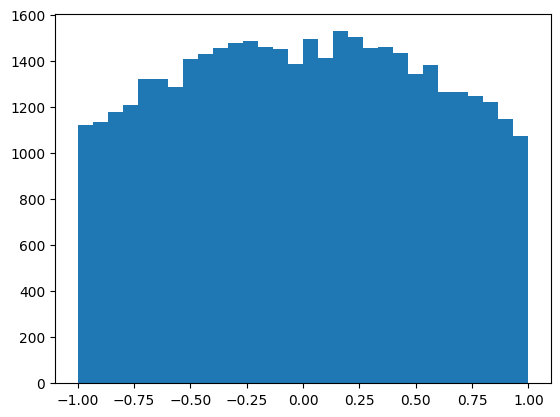

0.07056803


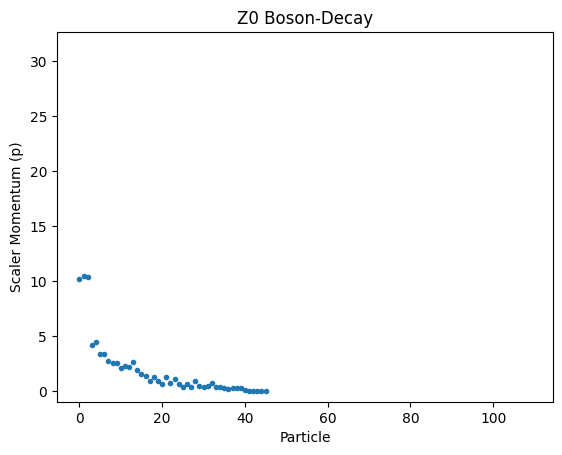

In [35]:
### First n_scalers are scaler(repeated) features 
plt.hist(X_train_seq[:, 0, 0], bins=30)
plt.show()

rn_event = random.randint(0, len(X_train_seq) - 1)

## For seq/sets (-2) is the decay-Particle scaler momentum
second_min = sorted(set(X_train_seq[rn_event, :, -2]), reverse=False)[1]
first_max = max(X_train_seq[rn_event, :, -2])
print(second_min)

plt.scatter(np.arange(len(X_train_seq[0, :, -2])), X_train_seq[0, :, -2], marker='.')
plt.ylim(second_min - 1, first_max)
plt.ylabel('Scaler Momentum (p)')
plt.xlabel('Particle')
plt.title('Z0 Boson-Decay')
plt.show()

### Save Data (Preprocessed)

In [36]:
print(X_filtered_seq.shape, X_val_seq.shape, X_test_seq.shape, y_filtered_seq.shape, y_val_seq.shape, y_test_seq.shape)

(39839, 110, 13) (2125, 110, 13) (7500, 110, 13) (39839,) (2125,) (7500,)


In [37]:
np.savez('data/preprocessed/data_seq.npz', 
         x_train=X_filtered_seq, x_val=X_val_seq, x_test=X_test_seq, 
         y_train=y_filtered_seq, y_val=y_val_seq, y_test=y_test_seq)

### Load Data (Preprocessed)

In [5]:
loaded_data = np.load('data/preprocessed/data_seq.npz')

X_filtered_seq = loaded_data['x_train']
X_val_seq = loaded_data['x_val']
X_test_seq = loaded_data['x_test']
y_filtered_seq = loaded_data['y_train']
y_val_seq = loaded_data['y_val']
y_test_seq = loaded_data['y_test']

In [6]:
print(X_filtered_seq.shape, X_val_seq.shape, X_test_seq.shape, y_filtered_seq.shape, y_val_seq.shape, y_test_seq.shape)

(39839, 110, 13) (2125, 110, 13) (7500, 110, 13) (39839,) (2125,) (7500,)


In [38]:
normalizer = Normalization(axis=-1) ## feature-wise Normalization (like StandardScaler())  
normalizer.adapt(X_filtered_seq) 

#### RNNs (GRU) -- Permutation Variant

In [42]:
import utils.model
import utils.train

importlib.reload(utils.model)
importlib.reload(utils.train)

from utils.model import *
from utils.train import *

In [43]:
# gru_model = gru_classifier_v1(input_shape=X_filtered_seq.shape[1:], normalizer=normalizer)
gru_model = gru_classifier_v2(input_shape=X_filtered_seq.shape[1:], normalizer=normalizer)
gru_model.summary()

c:\Users\Alik\Desktop\M_year\MPhil\Lent\A3\am3353\a3-env-2\Lib\site-packages\keras\src\layers\layer.py:939: UserWarning: Layer 'flatten_2' (of type Flatten) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 110, 13)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_2     │ (None, 110, 13)   │         27 │ input_layer_2[0]… │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, 110, 13)   │          0 │ normalization_2[… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_2 (Masking) │ (None, 110, 13)   │          0 │ normalization_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_2 (Any)         │ (None, 110)       │          0 │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 110, 64)   │      9,024 │ masking_2[0][0],  │
│ (Bidirectional)     │                   │            │ any_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 110, 64)   │        256 │ bidirectional_4[… │
│ (BatchNormalizatio… │                   │            │ any_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 110, 64)   │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 110, 64)   │     18,816 │ dropout_12[0][0], │
│ (Bidirectional)     │                   │            │ any_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 110, 64)   │          0 │ bidirectional_5[… │
│                     │                   │            │ bidirectional_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ logical_or_2        │ (None, 110)       │          0 │ any_2[0][0],      │
│ (LogicalOr)         │                   │            │ any_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 110, 64)   │        256 │ add_2[0][0],      │
│ (BatchNormalizatio… │                   │            │ logical_or_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 110, 64)   │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_6     │ (None, 110, 64)   │     18,816 │ dropout_13[0][0], │
│ (Bidirectional)     │                   │            │ logical_or_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 110, 64)   │          0 │ bidirectional_6[… │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ logical_or_3        │ (None, 110)       │          0 │ logical_or_2[0][… │
│ (LogicalOr)         │                   │            │ logical_or_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 110, 64)   │        256 │ add_3[0][0],      │
│ (BatchNormalizatio… │                   │            │ logical_or_3[0][… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 49,823 (194.62 KB)

 Trainable params: 49,348 (192.77 KB)

 Non-trainable params: 475 (1.86 KB)

In [44]:
ft = time.time()
history_rnn, gru_model = train_gru([X_filtered_seq, y_filtered_seq], [X_val_seq, y_val_seq], epochs=50)
lt = time.time()

print('time taken (train): ', (lt - ft) / 60, ' mins')

c:\Users\Alik\Desktop\M_year\MPhil\Lent\A3\am3353\a3-env-2\Lib\site-packages\keras\src\layers\layer.py:939: UserWarning: Layer 'flatten_3' (of type Flatten) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Epoch 1/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 305s 419ms/step - accuracy: 0.5666 - loss: 0.9768 - val_accuracy: 0.6842 - val_loss: 0.6905 - learning_rate: 0.0010
Epoch 2/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 243s 390ms/step - accuracy: 0.6400 - loss: 0.7753 - val_accuracy: 0.6955 - val_loss: 0.6645 - learning_rate: 0.0010
Epoch 3/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 246s 395ms/step - accuracy: 0.6591 - loss: 0.7507 - val_accuracy: 0.7073 - val_loss: 0.6519 - learning_rate: 0.0010
Epoch 4/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 231s 371ms/step - accuracy: 0.6695 - loss: 0.7320 - val_accuracy: 0.7096 - val_loss: 0.6471 - learning_rate: 0.0010
Epoch 5/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 243s 390ms/step - accuracy: 0.6724 - loss: 0.7258 - val_accuracy: 0.7139 - val_loss: 0.6478 - learning_rate: 0.0010
Epoch 6/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 247s 397ms/step - accuracy: 0.6756 - loss: 0.7163 - val_accuracy: 0.7012 - val_loss: 0.6560 - learning_rate: 0.0010
Epoch 7/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 249s 400ms/step - accura

time taken (train):  36.24587289094925  mins


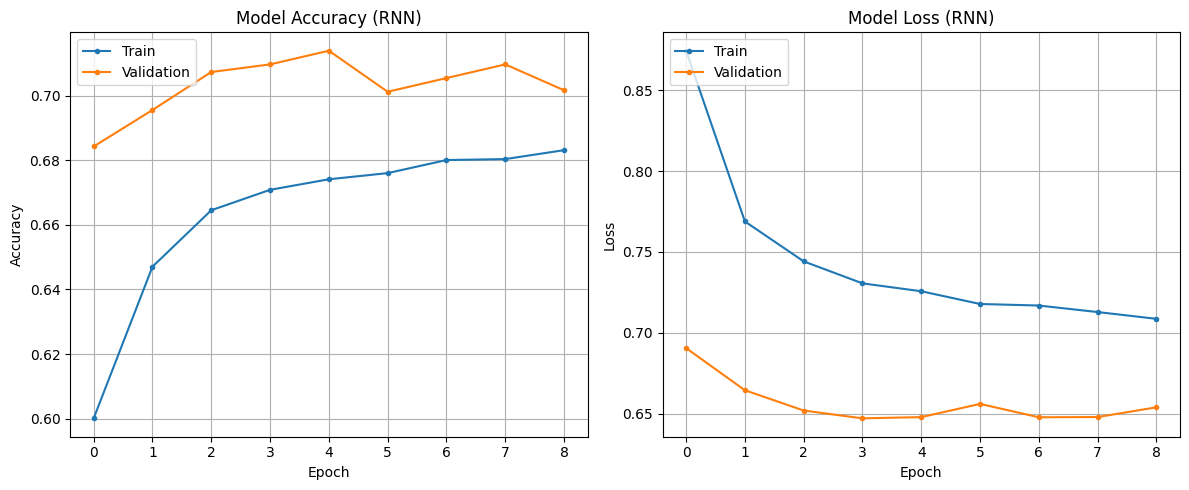

In [45]:
# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_rnn.history['accuracy'], marker = '.')
plt.plot(history_rnn.history['val_accuracy'], marker = '.')
plt.title('Model Accuracy (RNN)')
plt.grid()
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_rnn.history['loss'], marker = '.')
plt.plot(history_rnn.history['val_loss'], marker = '.')
plt.title('Model Loss (RNN)')
plt.grid()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.savefig('saves/plots/rnn_training_history.png')
plt.show()

### Metrics

235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - accuracy: 0.6860 - loss: 0.6908

Test accuracy: 0.6935
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 71ms/step
<class 'numpy.ndarray'> (7500, 3)

Classification Report:
              precision    recall  f1-score   support

         Zbb       0.73      0.78      0.75      2423
         Zcc       0.57      0.55      0.56      2475
         Zss       0.78      0.75      0.76      2602

   micro avg       0.69      0.69      0.69      7500
   macro avg       0.69      0.69      0.69      7500
weighted avg       0.69      0.69      0.69      7500
 samples avg       0.69      0.69      0.69      7500



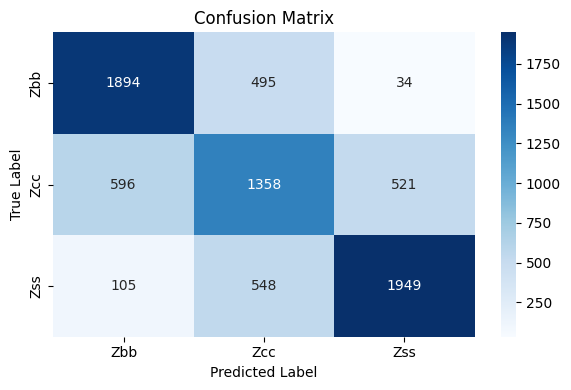

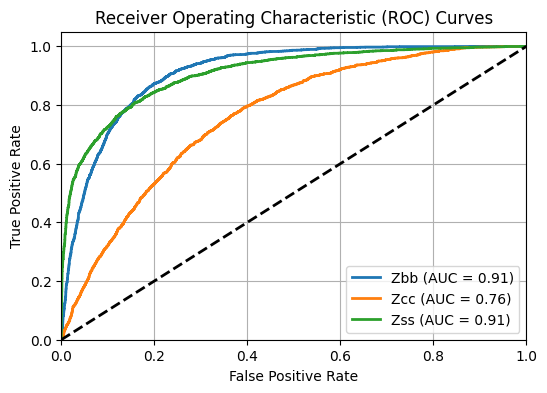

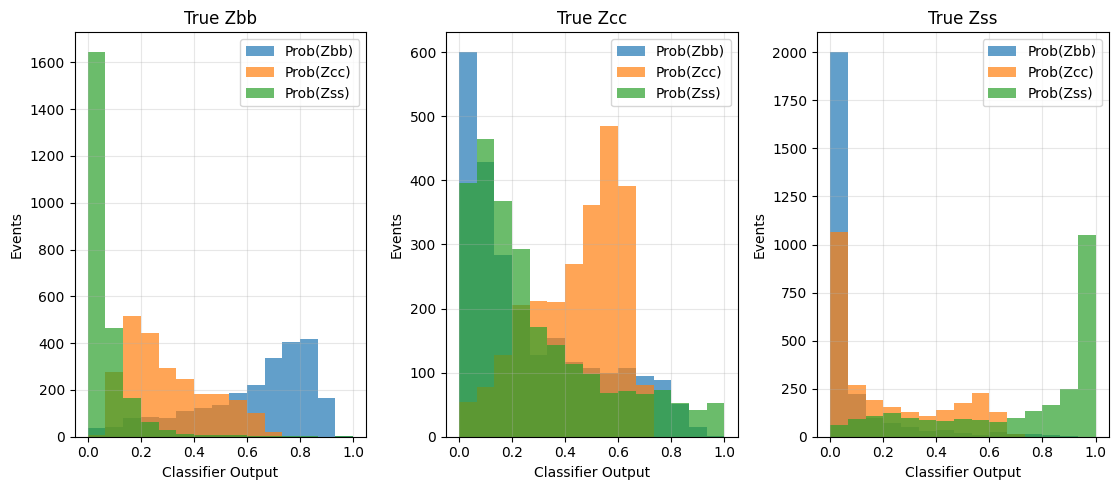

In [46]:

# Evaluate the model on the test set
test_loss, test_acc = gru_model.evaluate(X_test_seq, y_test_seq)
print(f"\nTest accuracy: {test_acc:.4f}")

# Predict using the dnn_model
y_pred_prob = gru_model.predict(X_test_seq)  # Model expects one input (X_test)
y_pred_prob = tf.nn.softmax(y_pred_prob, axis=-1).numpy()
print(type(y_pred_prob), y_pred_prob.shape)
y_pred = np.argmax(y_pred_prob, axis=1)
y_pred_one_hot = to_categorical(y_pred, num_classes=3)
y_test_one_hot = to_categorical(y_test_seq, num_classes=3)

# Generate classification report
print("\nClassification Report:")
print(classification_report(y_test_one_hot, y_pred_one_hot, target_names=['Zbb', 'Zcc', 'Zss']))

# Create confusion matrix
cm = confusion_matrix(y_test_seq, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Zbb', 'Zcc', 'Zss'],
            yticklabels=['Zbb', 'Zcc', 'Zss'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('saves/plots/rnn_confusion_matrix_c2.png')
plt.show()

# Plot ROC curves
plt.figure(figsize=(6, 4))

# One-vs-All ROC curves
for i, flavor in enumerate(['Zbb', 'Zcc', 'Zss']):
    # Convert to one-vs-all problem
    y_test_binary = (y_test_seq == i).astype(int)
    
    # Get ROC curve
    fpr, tpr, _ = roc_curve(y_test_binary, y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, lw=2, label=f'{flavor} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('saves/plots/rnn_roc_curves_c2.png')
plt.show()

# Visualize classifier outputs
plt.figure(figsize=(15, 5))

# Create 4 subplots, one for each flavor (Zbb, Zcc, Zss, Zud)
for i, flavor in enumerate(['Zbb', 'Zcc', 'Zss']):
    plt.subplot(1, 4, i+1)
    
    # Get indices of true examples for this flavor
    true_indices = np.where(y_test_seq == i)[0]
    
    # Plot distribution of classifier outputs for this flavor
    for j, pred_flavor in enumerate(['Zbb', 'Zcc', 'Zss']):
        plt.hist(y_pred_prob[true_indices, j], bins=15, alpha=0.7, 
                 label=f'Prob({pred_flavor})', range=(0, 1))
    
    plt.title(f'True {flavor}')
    plt.xlabel('Classifier Output')
    plt.ylabel('Events')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('saves/plots/rnn_classifier_outputs_c2.png')
plt.show()

### DeepSets - Permutation Invariance

### Fundamental Theorem Behind DeepSets

Let $X = \{x_1, x_2, \dots, x_n\}$, where each $x_i \in \mathbb{R}^d$. A function $f(X)$ is **permutation invariant** if:

$$
f(x_1, x_2, \dots, x_n) = f(x_{\pi(1)}, x_{\pi(2)}, \dots, x_{\pi(n)})
$$

for any permutation $\pi$ of the indices $\{1, 2, \dots, n\}$.

**Theorem (Zaheer et al., 2017):**  
Any permutation-invariant function $f$ operating on a set $X$ can be universally approximated by a function of the form:

$$
f(X) = \rho \left( \sum_{x \in X} \phi(x) \right)
$$

for suitable transformations $\phi: \mathbb{R}^d \to \mathbb{R}^k$ and $\rho: \mathbb{R}^k \to \mathbb{R}$, both of which can be parameterized by neural networks.

---

### Components of the Architecture

- **Element-wise transformation $\phi(x)$**:  
  A shared function (e.g., a multilayer perceptron) applied independently to each element $x \in X$, mapping it to a latent representation.

- **Aggregation $\sum_{x \in X} \phi(x)$**:  
  A permutation-invariant operation used to combine the individual representations into a fixed-size vector. Common choices include summation, averaging, or maximization.

- **Output transformation $\rho$**:  
  A function that maps the aggregated representation to the final output. This may correspond to a classification, regression, or other task-specific prediction.


In [7]:
import utils.model
import utils.train

importlib.reload(utils.model)
importlib.reload(utils.train)

from utils.model import *
from utils.train import *

In [8]:
normalizer = Normalization(axis=-1) ## feature-wise Normalization (like StandardScaler())  
normalizer.adapt(X_filtered_seq) 

In [9]:
# deepset_model = deepset_classifier_v1(input_shape=X_filtered_seq.shape[1:], normalizer=normalizer)
deepset_model = deepset_classifier_v2(input_shape=X_filtered_seq.shape[1:], normalizer=normalizer)
deepset_model.summary()

c:\Users\Alik\Desktop\M_year\MPhil\Lent\A3\am3353\a3-env-2\Lib\site-packages\keras\src\layers\layer.py:939: UserWarning: Layer 'lambda' (of type Lambda) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\Alik\Desktop\M_year\MPhil\Lent\A3\am3353\a3-env-2\Lib\site-packages\keras\src\layers\layer.py:939: UserWarning: Layer 'global_max_pooling1d' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 110, 13)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 110, 13)   │         27 │ input_layer[0][0] │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 110, 13)   │          0 │ normalization[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, 110, 13)   │          0 │ normalization[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any (Any)           │ (None, 110)       │          0 │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 110, 45)   │     18,135 │ masking[0][0],    │
│ (TimeDistributed)   │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 45)        │          0 │ time_distributed… │
│                     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 45)        │          0 │ time_distributed… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 90)        │          0 │ lambda[0][0],     │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │      2,912 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_4[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 16)        │        528 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16)        │         64 │ dense_5[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 3)         │         51 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 21,845 (85.34 KB)

 Trainable params: 21,182 (82.74 KB)

 Non-trainable params: 663 (2.59 KB)

In [10]:
history_deepset, deepset_model = train_deepset([X_filtered_seq, y_filtered_seq], [X_val_seq, y_val_seq], epochs=50)

c:\Users\Alik\Desktop\M_year\MPhil\Lent\A3\am3353\a3-env-2\Lib\site-packages\keras\src\layers\layer.py:939: UserWarning: Layer 'lambda_1' (of type Lambda) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\Alik\Desktop\M_year\MPhil\Lent\A3\am3353\a3-env-2\Lib\site-packages\keras\src\layers\layer.py:939: UserWarning: Layer 'global_max_pooling1d_1' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Epoch 1/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 191s 115ms/step - accuracy: 0.4721 - loss: 1.2604 - val_accuracy: 0.6353 - val_loss: 0.7664 - learning_rate: 1.0000e-04
Epoch 2/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 61s 98ms/step - accuracy: 0.5980 - loss: 0.9100 - val_accuracy: 0.6640 - val_loss: 0.7231 - learning_rate: 1.0000e-04
Epoch 3/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 61s 97ms/step - accuracy: 0.6255 - loss: 0.8378 - val_accuracy: 0.6744 - val_loss: 0.6961 - learning_rate: 1.0000e-04
Epoch 4/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 60s 97ms/step - accuracy: 0.6470 - loss: 0.8014 - val_accuracy: 0.6805 - val_loss: 0.6856 - learning_rate: 1.0000e-04
Epoch 5/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 79s 127ms/step - accuracy: 0.6547 - loss: 0.7759 - val_accuracy: 0.6814 - val_loss: 0.6802 - learning_rate: 1.0000e-04
Epoch 6/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 76s 122ms/step - accuracy: 0.6637 - loss: 0.7531 - val_accuracy: 0.6871 - val_loss: 0.6812 - learning_rate: 1.0000e-04
Epoch 7/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 77s 123m

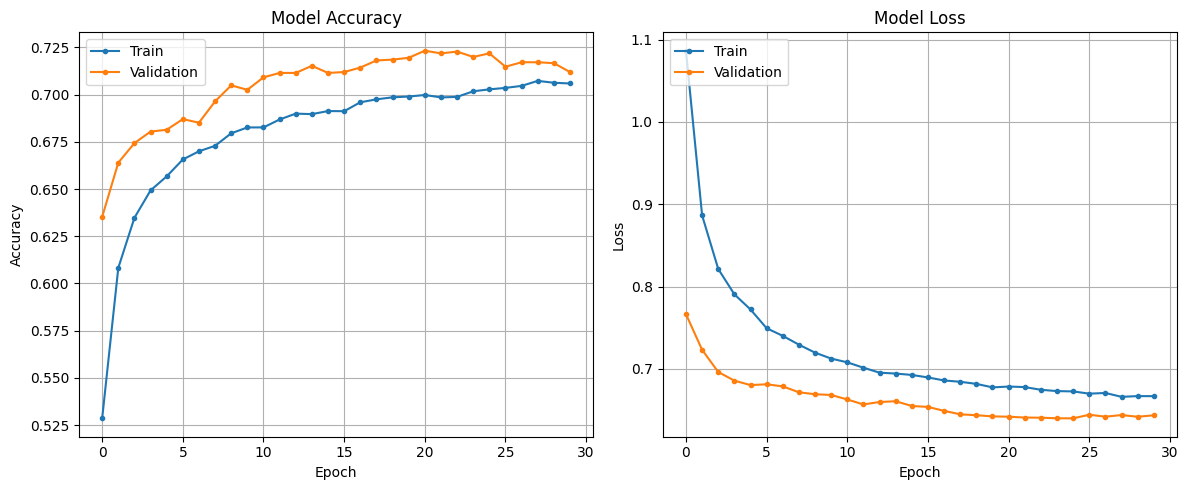

In [11]:
# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_deepset.history['accuracy'], marker = '.')
plt.plot(history_deepset.history['val_accuracy'], marker = '.')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_deepset.history['loss'], marker = '.')
plt.plot(history_deepset.history['val_loss'], marker = '.')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.savefig('saves/plots/deepsets_training_history.png')
plt.show()

### Metrics

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7220 - loss: 0.6426

Test accuracy: 0.7219
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step

Classification Report:
              precision    recall  f1-score   support

         Zbb       0.77      0.74      0.75      2423
         Zcc       0.54      0.66      0.60      2475
         Zss       0.83      0.67      0.74      2602

   micro avg       0.69      0.69      0.69      7500
   macro avg       0.71      0.69      0.70      7500
weighted avg       0.71      0.69      0.70      7500
 samples avg       0.69      0.69      0.69      7500



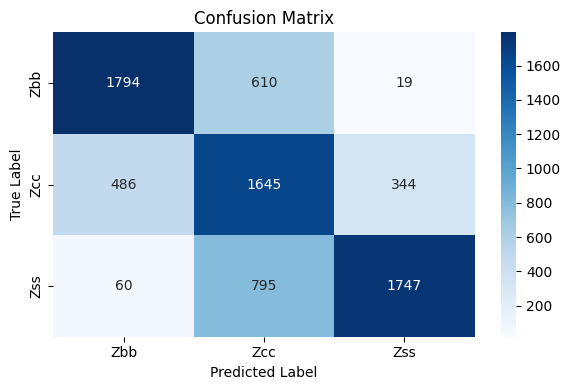

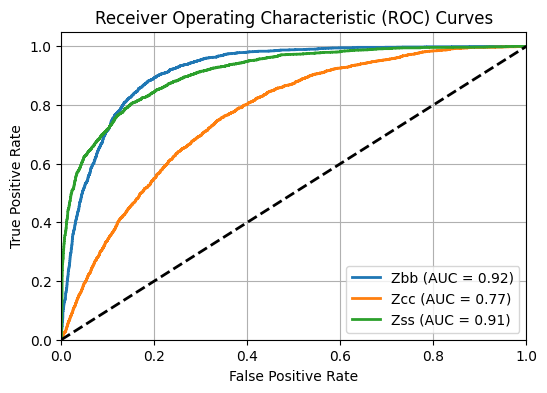

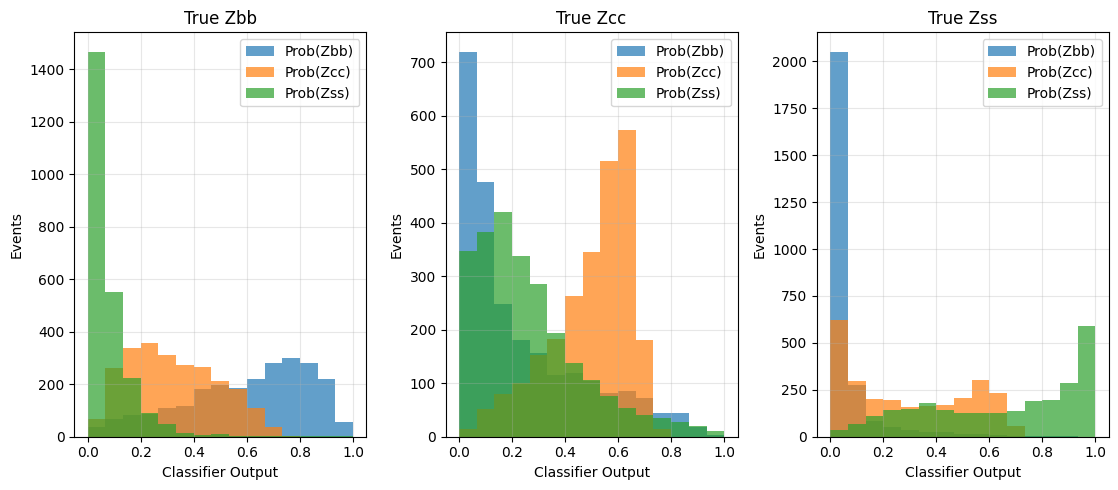

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = deepset_model.evaluate(X_test_seq, y_test_seq)
print(f"\nTest accuracy: {test_acc:.4f}")

# Predict using the dnn_model
y_pred_prob = deepset_model.predict(X_test_seq)  # Model expects one input (X_test)
y_pred_prob = tf.nn.softmax(y_pred_prob, axis=-1).numpy()
y_pred = np.argmax(y_pred_prob, axis=1)
y_pred_one_hot = to_categorical(y_pred, num_classes=3)
y_test_one_hot = to_categorical(y_test_seq, num_classes=3)

# Generate classification report
print("\nClassification Report:")
print(classification_report(y_test_one_hot, y_pred_one_hot, target_names=['Zbb', 'Zcc', 'Zss']))

# Create confusion matrix
cm = confusion_matrix(y_test_seq, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Zbb', 'Zcc', 'Zss'],
            yticklabels=['Zbb', 'Zcc', 'Zss'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('saves/plots/deepsets_confusion_matrix.png')
plt.show()

# Plot ROC curves
plt.figure(figsize=(6, 4))

# One-vs-All ROC curves
for i, flavor in enumerate(['Zbb', 'Zcc', 'Zss']):
    # Convert to one-vs-all problem
    y_test_binary = (y_test_seq == i).astype(int)
    
    # Get ROC curve
    fpr, tpr, _ = roc_curve(y_test_binary, y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, lw=2, label=f'{flavor} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('saves/plots/deepsets_roc_curves.png')
plt.show()

# Visualize classifier outputs
plt.figure(figsize=(15, 5))

# Create 4 subplots, one for each flavor (Zbb, Zcc, Zss, Zud)
for i, flavor in enumerate(['Zbb', 'Zcc', 'Zss']):
    plt.subplot(1, 4, i+1)
    
    # Get indices of true examples for this flavor
    true_indices = np.where(y_test_seq == i)[0]
    # Plot distribution of classifier outputs for this flavor
    for j, pred_flavor in enumerate(['Zbb', 'Zcc', 'Zss']):
        plt.hist(y_pred_prob[true_indices, j], bins=15, alpha=0.7, 
                 label=f'Prob({pred_flavor})', range=(0, 1))
    
    plt.title(f'True {flavor}')
    plt.xlabel('Classifier Output')
    plt.ylabel('Events')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('saves/plots/deepset_classifier_outputs.png')
plt.show()